<a href="https://colab.research.google.com/github/manishaachary13/Space-Launch-Mission/blob/main/mission%20launch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✈️ Project Title:  **Big Data Analytics of Global Space Launch Missions**

# **🧩 Problem Statement:**

With the rise of both government and private space agencies, the number of satellite and exploratory missions has increased rapidly. However, delays, failures, and cost overruns still pose a serious challenge. This project aims to use Big Data tools (specifically PySpark) to analyze historical space launch data, uncover patterns in successful/failed missions, and predict mission outcomes.

This project aims to utilize **Big Data analytics using PySpark** to process and analyze historical global space launch mission data. The goals are to:
* Identify patterns and trends in space launch activity over time.
* Analyze mission success/failure based on organization, rocket status, launch site, or launch type.
* Explore cost drivers in space missions and the relationship between cost and success.
* Predict mission outcomes (success/failure) using classification models.

## 🛰️ Key Features in the Dataset:


Organisation: Agency or private company (e.g., SpaceX, ISRO, NASA, Roscosmos)

Location: Launch site

Date: Mission launch date

Detail: Description of the mission

Rocket_Status: Operational status of the rocket

Price: Launch cost (in million USD)

Mission_Status: Outcome of the mission (e.g., Success, Failure, Partial Failure)

# **Load the Dataset and Data Preprocessing**

#### 📦 1. Install and Configure PySpark

In [1]:
# 1. Install Java and PySpark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install -q pyspark findspark

# 2. Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

# 3. Initialize Findspark
import findspark
findspark.init()

# 4. Start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SpaceLaunchBigData") \
    .getOrCreate()

print("✅ Spark Session Created Successfully")



✅ Spark Session Created Successfully


#### Load CSV (from Github)

In [2]:
!wget -O mission_launches.csv "https://raw.githubusercontent.com/manishaachary13/Space-Launch-Mission/refs/heads/main/mission_launches.csv"


--2025-04-14 13:29:56--  https://raw.githubusercontent.com/manishaachary13/Space-Launch-Mission/refs/heads/main/mission_launches.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 632009 (617K) [text/plain]
Saving to: ‘mission_launches.csv’

mission_launches.cs 100%[===================>] 617.20K  --.-KB/s    in 0.03s   

2025-04-14 13:29:57 (19.3 MB/s) - ‘mission_launches.csv’ saved [632009/632009]



In [3]:
df = spark.read.csv("mission_launches.csv", header=True, inferSchema=True)

#### Basic Informations

In [4]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Unnamed: 0: integer (nullable = true)
 |-- Organisation: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Detail: string (nullable = true)
 |-- Rocket_Status: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Mission_Status: string (nullable = true)



In [5]:
df.show(5, truncate=False)

+---+----------+------------+---------------------------------------------------------+--------------------------+--------------------------------------------+-------------+-----+--------------+
|_c0|Unnamed: 0|Organisation|Location                                                 |Date                      |Detail                                      |Rocket_Status|Price|Mission_Status|
+---+----------+------------+---------------------------------------------------------+--------------------------+--------------------------------------------+-------------+-----+--------------+
|0  |0         |SpaceX      |LC-39A, Kennedy Space Center, Florida, USA               |Fri Aug 07, 2020 05:12 UTC|Falcon 9 Block 5 | Starlink V1 L9 & BlackSky|StatusActive |50.0 |Success       |
|1  |1         |CASC        |Site 9401 (SLS-2), Jiuquan Satellite Launch Center, China|Thu Aug 06, 2020 04:01 UTC|Long March 2D | Gaofen-9 04 & Q-SAT         |StatusActive |29.75|Success       |
|2  |2         |SpaceX   

In [6]:
print("Number of Rows:", df.count())
print("Number of Columns:", len(df.columns))

Number of Rows: 4324
Number of Columns: 9


#### Describe numerical columns

In [7]:
df.describe().show()

+-------+------------------+------------------+------------+--------------------+--------------------+--------------------+-------------+------------------+--------------+
|summary|               _c0|        Unnamed: 0|Organisation|            Location|                Date|              Detail|Rocket_Status|             Price|Mission_Status|
+-------+------------------+------------------+------------+--------------------+--------------------+--------------------+-------------+------------------+--------------+
|  count|              4324|              4324|        4324|                4324|                4324|                4324|         4324|               964|          4324|
|   mean|            2161.5|            2161.5|        NULL|                NULL|                NULL|                NULL|         NULL|129.79523709167552|          NULL|
| stddev|1248.3756112110916|1248.3756112110916|        NULL|                NULL|                NULL|                NULL|         NULL| 14

#### Checking for Missing Values(Column-wise)

In [8]:
from pyspark.sql.functions import col, when, count, isnan

df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

+---+----------+------------+--------+----+------+-------------+-----+--------------+
|_c0|Unnamed: 0|Organisation|Location|Date|Detail|Rocket_Status|Price|Mission_Status|
+---+----------+------------+--------+----+------+-------------+-----+--------------+
|  0|         0|           0|       0|   0|     0|            0| 3360|             0|
+---+----------+------------+--------+----+------+-------------+-----+--------------+



#### Unique Values per column

In [9]:
for col_name in df.columns:
    df.select(col_name).distinct().count()
    print(f"Unique values in '{col_name}':", df.select(col_name).distinct().count())

Unique values in '_c0': 4324
Unique values in 'Unnamed: 0': 4324
Unique values in 'Organisation': 56
Unique values in 'Location': 137
Unique values in 'Date': 4319
Unique values in 'Detail': 4278
Unique values in 'Rocket_Status': 2
Unique values in 'Price': 57
Unique values in 'Mission_Status': 4


#### Column names and Their Datatypes

In [10]:
[(name, dtype) for name, dtype in df.dtypes]

[('_c0', 'int'),
 ('Unnamed: 0', 'int'),
 ('Organisation', 'string'),
 ('Location', 'string'),
 ('Date', 'string'),
 ('Detail', 'string'),
 ('Rocket_Status', 'string'),
 ('Price', 'string'),
 ('Mission_Status', 'string')]

#### Frequecy of each mission status

In [11]:
df.groupBy("Mission_Status").count().orderBy("count", ascending=False).show()

+-----------------+-----+
|   Mission_Status|count|
+-----------------+-----+
|          Success| 3879|
|          Failure|  339|
|  Partial Failure|  102|
|Prelaunch Failure|    4|
+-----------------+-----+



#### Frequency of each rocket status

In [12]:
df.groupBy("Rocket_Status").count().orderBy("count", ascending=False).show()

+-------------+-----+
|Rocket_Status|count|
+-------------+-----+
|StatusRetired| 3534|
| StatusActive|  790|
+-------------+-----+



#### Check for blank strings

In [13]:
from pyspark.sql.functions import length, trim

df.select([count(when(trim(col(c)) == "", c)).alias(c) for c in df.columns]).show()

+---+----------+------------+--------+----+------+-------------+-----+--------------+
|_c0|Unnamed: 0|Organisation|Location|Date|Detail|Rocket_Status|Price|Mission_Status|
+---+----------+------------+--------+----+------+-------------+-----+--------------+
|  0|         0|           0|       0|   0|     0|            0|    0|             0|
+---+----------+------------+--------+----+------+-------------+-----+--------------+



####  Check for Duplicate rows

In [14]:
duplicates = df.groupBy(df.columns).count().filter("count > 1")
print("Number of duplicate rows:", duplicates.count())

Number of duplicate rows: 0


#### Length of tect columns

In [15]:
from pyspark.sql.functions import length

df.select("Organisation", length(col("Organisation")).alias("Length")).show(5)

+------------+------+
|Organisation|Length|
+------------+------+
|      SpaceX|     6|
|        CASC|     4|
|      SpaceX|     6|
|   Roscosmos|     9|
|         ULA|     3|
+------------+------+
only showing top 5 rows



#### Distribution of data in numerial columns

In [16]:
df.select("Price").describe().show()

+-------+------------------+
|summary|             Price|
+-------+------------------+
|  count|               964|
|   mean|129.79523709167552|
| stddev| 143.2203233531596|
|    min|           1,160.0|
|    max|              90.0|
+-------+------------------+



#### Check for mixed data types

In [17]:
df.select("Price").distinct().orderBy("Price").show(20)

+-------+
|  Price|
+-------+
|   NULL|
|1,160.0|
|  109.0|
|  112.5|
|  115.0|
|   12.0|
|  120.0|
|  123.0|
|  130.0|
|  133.0|
|  135.0|
|  136.6|
|  140.0|
|  145.0|
|   15.0|
|  153.0|
|  164.0|
|  190.0|
|   20.0|
|  20.14|
+-------+
only showing top 20 rows



####Sample Date Checks (Earliest & Latest)

In [18]:
df.select("Date").orderBy("Date").show(5)  # Earliest
df.select("Date").orderBy("Date", ascending=False).show(5)  # Latest

+--------------------+
|                Date|
+--------------------+
|Fri Apr 01, 1960 ...|
|Fri Apr 02, 1971 ...|
|Fri Apr 02, 1999 ...|
|Fri Apr 02, 2010 ...|
|Fri Apr 03, 1970 ...|
+--------------------+
only showing top 5 rows

+--------------------+
|                Date|
+--------------------+
|Wed Sep 30, 2015 ...|
|Wed Sep 30, 1981 ...|
|Wed Sep 29, 1976 ...|
|Wed Sep 29, 1971 ...|
|Wed Sep 28, 1983 ...|
+--------------------+
only showing top 5 rows



####Top Launching Organizations

In [19]:
df.groupBy("Organisation").count().orderBy("count", ascending=False).show(10)

+----------------+-----+
|    Organisation|count|
+----------------+-----+
|       RVSN USSR| 1777|
|     Arianespace|  279|
|            CASC|  251|
|General Dynamics|  251|
|            NASA|  203|
|          VKS RF|  201|
|    US Air Force|  161|
|             ULA|  140|
|          Boeing|  136|
| Martin Marietta|  114|
+----------------+-----+
only showing top 10 rows



#### Detecting columns with constant or low variance values

In [20]:
for c in df.columns:
    unique_count = df.select(c).distinct().count()
    if unique_count <= 2:
        print(f"Column '{c}' has low variance: only {unique_count} unique values")

Column 'Rocket_Status' has low variance: only 2 unique values


#### Null Value Matrix for visual inspection

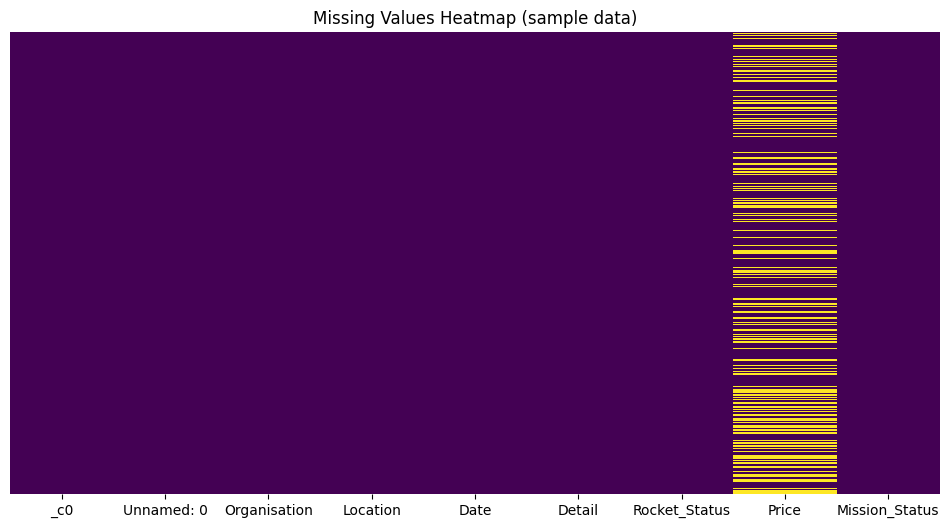

In [21]:
sample_df = df.limit(1000).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(sample_df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Heatmap (sample data)")
plt.show()

#### View Potential Typos in 'Organisation

In [22]:
df.select("Organisation").distinct().orderBy("Organisation").show(50, truncate=False)

+----------------+
|Organisation    |
+----------------+
|AEB             |
|AMBA            |
|ASI             |
|Arianespace     |
|Arm??e de l'Air |
|Blue Origin     |
|Boeing          |
|CASC            |
|CASIC           |
|CECLES          |
|CNES            |
|Douglas         |
|EER             |
|ESA             |
|Eurockot        |
|ExPace          |
|Exos            |
|General Dynamics|
|IAI             |
|ILS             |
|IRGC            |
|ISA             |
|ISAS            |
|ISRO            |
|JAXA            |
|KARI            |
|KCST            |
|Khrunichev      |
|Kosmotras       |
|Land Launch     |
|Landspace       |
|Lockheed        |
|MHI             |
|MITT            |
|Martin Marietta |
|NASA            |
|Northrop        |
|OKB-586         |
|OneSpace        |
|RAE             |
|RVSN USSR       |
|Rocket Lab      |
|Roscosmos       |
|SRC             |
|Sandia          |
|Sea Launch      |
|SpaceX          |
|Starsem         |
|ULA             |
|US Air Forc

### 🔍 **What We Have Done So Far**

1. **Created Spark Session**  
   ✔️ Successfully started Spark in Colab.

2. **Loaded the Dataset**  
   ✔️ Read CSV file using `spark.read.csv()` with headers and schema detection.

3. **Checked Dataset Info**
   - Viewed schema with `printSchema()`
   - Previewed rows with `.show()`
   - Counted rows and columns

4. **Described Numerical Columns**
   ✔️ Used `.describe()` to get count, mean, min, max, etc.

5. **Checked Missing Values**
   - Found `null`, `NaN`, and **blank values** in some columns.

6. **Checked Unique Values**
   ✔️ Counted unique entries in each column.

7. **Top Categories**
   - Most frequent **Organisations**
   - Most used **Locations**
   - Count of each **Mission_Status** and **Rocket_Status**

8. **Low Variance Columns**
   ✔️ Found columns with only 1–2 unique values (less useful for analysis).

9. **Date Range Check**
   ✔️ Found the earliest and latest mission dates.

10. **Duplicate Rows**
   ✔️ Checked for repeated rows in the dataset.

11. **Potential Typos**
   ✔️ Reviewed all unique values in `Organisation` to spot inconsistent names.


# **Data Cleaning or Data Wrangling**

In [23]:
from pyspark.sql.functions import regexp_replace

# Remove $ and , then convert to float
df = df.withColumn("Price", regexp_replace(col("Price"), "[$,]", "").cast("double"))

In [24]:
df.printSchema()
df.show(5)
df.describe().show()

root
 |-- _c0: integer (nullable = true)
 |-- Unnamed: 0: integer (nullable = true)
 |-- Organisation: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Detail: string (nullable = true)
 |-- Rocket_Status: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Mission_Status: string (nullable = true)

+---+----------+------------+--------------------+--------------------+--------------------+-------------+-----+--------------+
|_c0|Unnamed: 0|Organisation|            Location|                Date|              Detail|Rocket_Status|Price|Mission_Status|
+---+----------+------------+--------------------+--------------------+--------------------+-------------+-----+--------------+
|  0|         0|      SpaceX|LC-39A, Kennedy S...|Fri Aug 07, 2020 ...|Falcon 9 Block 5 ...| StatusActive| 50.0|       Success|
|  1|         1|        CASC|Site 9401 (SLS-2)...|Thu Aug 06, 2020 ...|Long March 2D | G...| StatusActive|29.75|     

In [25]:
median_price = df.select("Price").dropna().toPandas()["Price"].median()
df = df.fillna({"Price": median_price})

In [26]:
df.select(count(when(col("Price").isNull(), "Price"))).show()

+-----------------------------------------------+
|count(CASE WHEN (Price IS NULL) THEN Price END)|
+-----------------------------------------------+
|                                              0|
+-----------------------------------------------+



Add Flag Column: To know which rows originally had missing values:

In [27]:
from pyspark.sql.functions import when

df = df.withColumn("Price_Filled", when(df["Price"] == median_price, "Filled").otherwise("Original"))

In [28]:
df = df.drop("_c0")

In [29]:
df.printSchema()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- Organisation: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Detail: string (nullable = true)
 |-- Rocket_Status: string (nullable = true)
 |-- Price: double (nullable = false)
 |-- Mission_Status: string (nullable = true)
 |-- Price_Filled: string (nullable = false)



In [30]:
df.show()

+----------+------------+--------------------+--------------------+--------------------+-------------+-----+--------------+------------+
|Unnamed: 0|Organisation|            Location|                Date|              Detail|Rocket_Status|Price|Mission_Status|Price_Filled|
+----------+------------+--------------------+--------------------+--------------------+-------------+-----+--------------+------------+
|         0|      SpaceX|LC-39A, Kennedy S...|Fri Aug 07, 2020 ...|Falcon 9 Block 5 ...| StatusActive| 50.0|       Success|    Original|
|         1|        CASC|Site 9401 (SLS-2)...|Thu Aug 06, 2020 ...|Long March 2D | G...| StatusActive|29.75|       Success|    Original|
|         2|      SpaceX|Pad A, Boca Chica...|Tue Aug 04, 2020 ...|Starship Prototyp...| StatusActive| 62.0|       Success|      Filled|
|         3|   Roscosmos|Site 200/39, Baik...|Thu Jul 30, 2020 ...|Proton-M/Briz-M |...| StatusActive| 65.0|       Success|    Original|
|         4|         ULA|SLC-41, Cape Can

In [31]:
from pyspark.sql.functions import split, trim, size, col

# Step 1: Create a new array column by splitting Location
df = df.withColumn("Location_parts", split(col("Location"), ","))

# Step 2: Get the last element using size()-1
df = df.withColumn("Country", trim(col("Location_parts").getItem(size(col("Location_parts")) - 1)))

# Step 3: Drop the helper column if not needed
df = df.drop("Location_parts")

/usr/local/lib/python3.11/dist-packages/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


In [32]:
df.select("Location", "Country").show(10, truncate=False)

+---------------------------------------------------------+----------+
|Location                                                 |Country   |
+---------------------------------------------------------+----------+
|LC-39A, Kennedy Space Center, Florida, USA               |USA       |
|Site 9401 (SLS-2), Jiuquan Satellite Launch Center, China|China     |
|Pad A, Boca Chica, Texas, USA                            |USA       |
|Site 200/39, Baikonur Cosmodrome, Kazakhstan             |Kazakhstan|
|SLC-41, Cape Canaveral AFS, Florida, USA                 |USA       |
|LC-9, Taiyuan Satellite Launch Center, China             |China     |
|Site 31/6, Baikonur Cosmodrome, Kazakhstan               |Kazakhstan|
|LC-101, Wenchang Satellite Launch Center, China          |China     |
|SLC-40, Cape Canaveral AFS, Florida, USA                 |USA       |
|LA-Y1, Tanegashima Space Center, Japan                   |Japan     |
+---------------------------------------------------------+----------+
only s

In [33]:
df.select("Country").distinct().show(50, truncate=False)

+------------------------------+
|Country                       |
+------------------------------+
|Russia                        |
|France                        |
|China                         |
|India                         |
|Gran Canaria                  |
|Iran                          |
|Pacific Missile Range Facility|
|Barents Sea                   |
|Israel                        |
|New Mexico                    |
|USA                           |
|North Korea                   |
|South Korea                   |
|Shahrud Missile Test Site     |
|Yellow Sea                    |
|Pacific Ocean                 |
|Brazil                        |
|Kenya                         |
|Japan                         |
|New Zealand                   |
|Australia                     |
|Kazakhstan                    |
+------------------------------+



In [34]:
df.groupBy("Country").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|             Country|count|
+--------------------+-----+
|              Russia| 1395|
|                 USA| 1344|
|          Kazakhstan|  701|
|              France|  303|
|               China|  268|
|               Japan|  126|
|               India|   76|
|       Pacific Ocean|   36|
|                Iran|   13|
|         New Zealand|   13|
|              Israel|   11|
|               Kenya|    9|
|           Australia|    6|
|         North Korea|    5|
|          New Mexico|    4|
|         Barents Sea|    3|
|         South Korea|    3|
|              Brazil|    3|
|        Gran Canaria|    2|
|Pacific Missile R...|    1|
+--------------------+-----+
only showing top 20 rows



In [35]:

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


In [36]:
from pyspark.sql.functions import regexp_replace, to_timestamp, year

# Remove "UTC" from date string
df = df.withColumn("Parsed_Date", regexp_replace("Date", " UTC", ""))

# Convert to timestamp
df = df.withColumn("Parsed_Date", to_timestamp("Parsed_Date", "EEE MMM dd, yyyy HH:mm"))


In [37]:
df = df.drop("Date")
df = df.withColumnRenamed("Parsed_Date", "Date")



In [38]:
df.select("Date").show(5, truncate=False)


+-------------------+
|Date               |
+-------------------+
|2020-08-07 05:12:00|
|2020-08-06 04:01:00|
|2020-08-04 23:57:00|
|2020-07-30 21:25:00|
|2020-07-30 11:50:00|
+-------------------+
only showing top 5 rows



In [39]:
df = df.withColumn("Year", year("Date"))


In [40]:
df.show()

+----------+------------+--------------------+--------------------+-------------+-----+--------------+------------+-----------+-------------------+----+
|Unnamed: 0|Organisation|            Location|              Detail|Rocket_Status|Price|Mission_Status|Price_Filled|    Country|               Date|Year|
+----------+------------+--------------------+--------------------+-------------+-----+--------------+------------+-----------+-------------------+----+
|         0|      SpaceX|LC-39A, Kennedy S...|Falcon 9 Block 5 ...| StatusActive| 50.0|       Success|    Original|        USA|2020-08-07 05:12:00|2020|
|         1|        CASC|Site 9401 (SLS-2)...|Long March 2D | G...| StatusActive|29.75|       Success|    Original|      China|2020-08-06 04:01:00|2020|
|         2|      SpaceX|Pad A, Boca Chica...|Starship Prototyp...| StatusActive| 62.0|       Success|      Filled|        USA|2020-08-04 23:57:00|2020|
|         3|   Roscosmos|Site 200/39, Baik...|Proton-M/Briz-M |...| StatusActive| 

# EDA

#### Chart - 1:

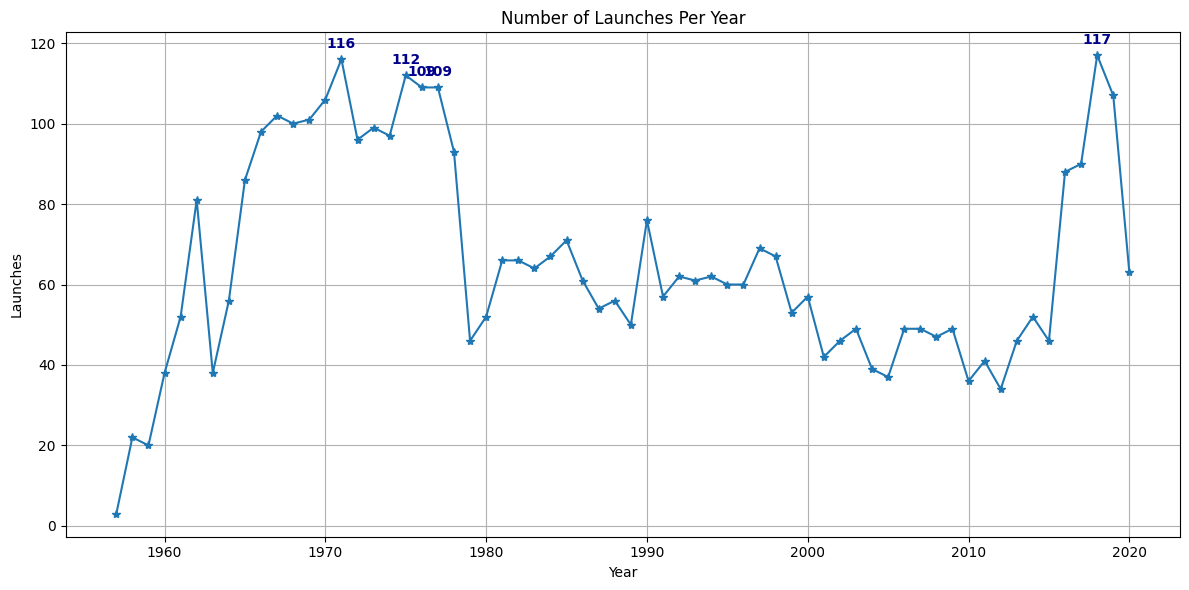

In [41]:
from pyspark.sql.functions import year
import matplotlib.pyplot as plt

# Count launches per year
launches_per_year = df.groupBy("Year").count().orderBy("Year")

# Convert to Pandas for plotting
launches_per_year_pd = launches_per_year.toPandas()

# Sort to find top 5 years with most launches
top5 = launches_per_year_pd.sort_values(by="count", ascending=False).head(6)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(launches_per_year_pd['Year'], launches_per_year_pd['count'], marker='*')
plt.title('Number of Launches Per Year')
plt.xlabel('Year')
plt.ylabel('Launches')
plt.grid(True)

# Annotate top 5 points
for _, row in top5.iterrows():
    plt.text(row['Year'], row['count'] + 2, f"{int(row['count'])}",
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='darkblue')

plt.tight_layout()
plt.show()



The highest frequency of space launches was observed during the early 1970s and 1980s, indicating a period of heightened global activity in space exploration and satellite deployment.

#### Chary - 2:

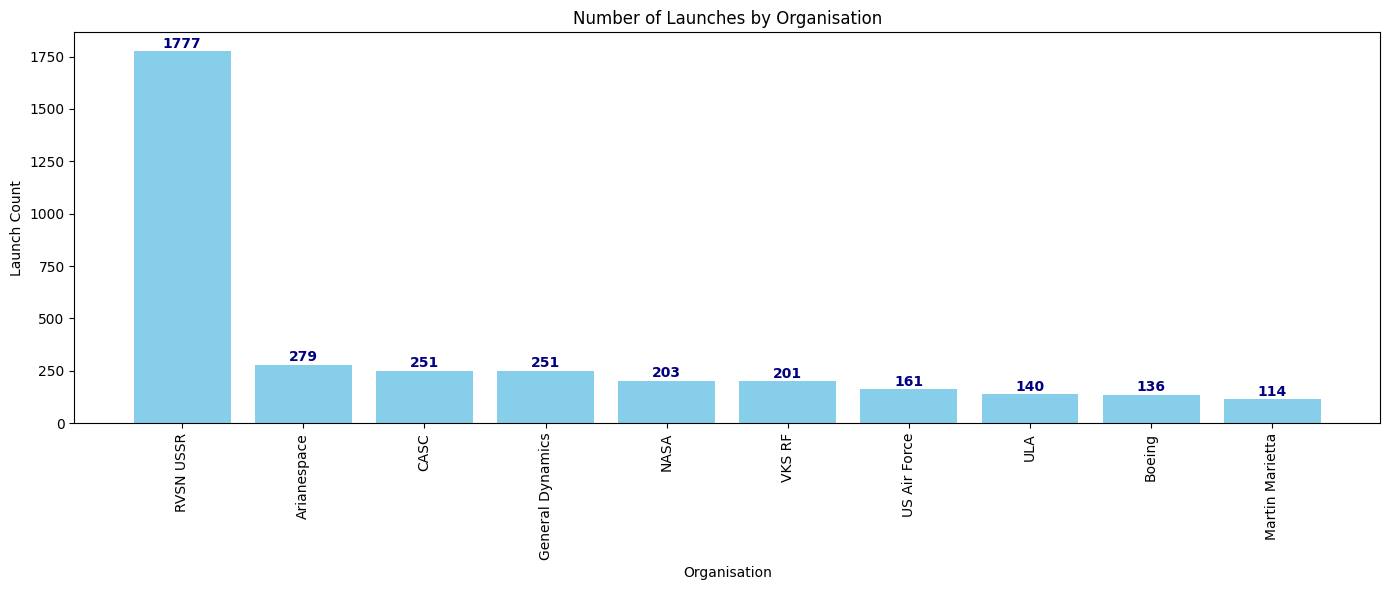

In [42]:
import matplotlib.pyplot as plt
launches_by_org = df.groupBy("Organisation").count().orderBy("count", ascending=False)
launches_by_org_pd = launches_by_org.toPandas()

# Bar plot with labels
plt.figure(figsize=(14, 6))
bars = plt.bar(launches_by_org_pd['Organisation'][:10], launches_by_org_pd['count'][:10], color='skyblue')

plt.xticks(rotation=90)
plt.title('Number of Launches by Organisation')
plt.xlabel('Organisation')
plt.ylabel('Launch Count')

# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1,  # slight offset
             f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='navy')

plt.tight_layout()
plt.show()


#### Chart - 3:

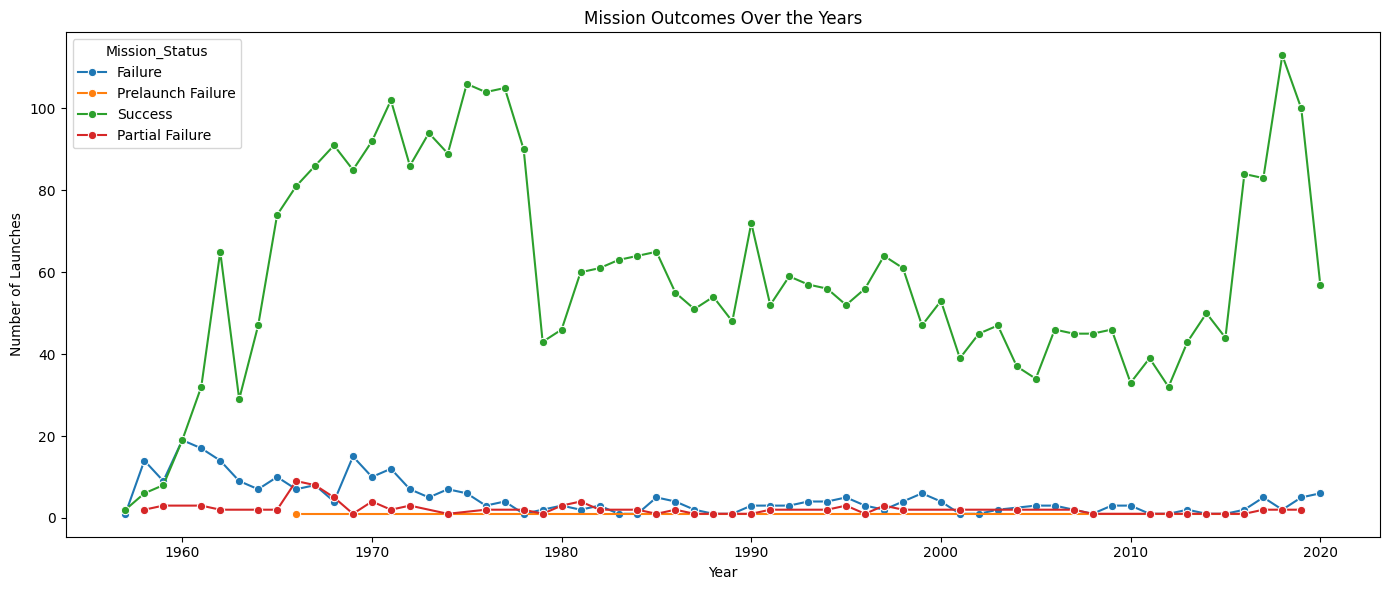

In [43]:
mission_status_by_year = df.groupBy("Year", "Mission_Status").count().orderBy("Year", "Mission_Status")
mission_status_by_year_pd = mission_status_by_year.toPandas()

import seaborn as sns

plt.figure(figsize=(14, 6))
sns.lineplot(data=mission_status_by_year_pd, x="Year", y="count", hue="Mission_Status", marker="o")
plt.title("Mission Outcomes Over the Years")
plt.ylabel("Number of Launches")
plt.tight_layout()
plt.show()


#### Chart - 4:

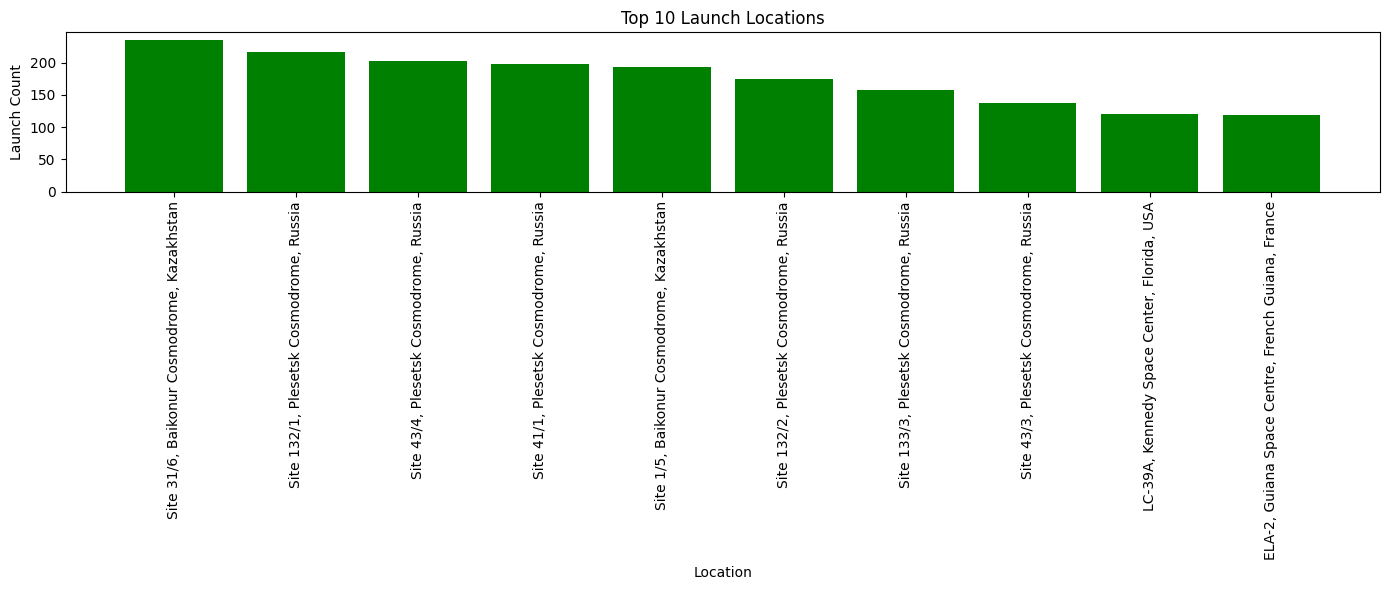

In [44]:
# Group by Location
launches_by_location = df.groupBy("Location").count().orderBy("count", ascending=False)

# Convert to Pandas
launches_by_location_pd = launches_by_location.toPandas()

# Bar Plot
plt.figure(figsize=(14, 6))
plt.bar(launches_by_location_pd['Location'][:10], launches_by_location_pd['count'][:10], color='green')
plt.xticks(rotation=90)
plt.title('Top 10 Launch Locations')
plt.xlabel('Location')
plt.ylabel('Launch Count')
plt.tight_layout()
plt.show()


#### Chart - 5:

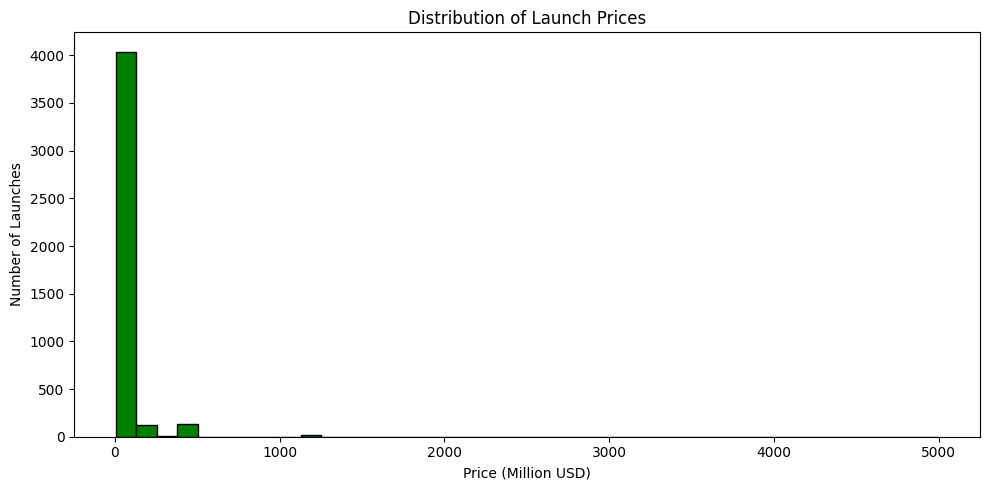

In [45]:
# Remove nulls in Price
df_price = df.filter(df.Price.isNotNull())

# Convert to Pandas
price_pd = df_price.select("Price").toPandas()

# Histogram
plt.figure(figsize=(10, 5))
plt.hist(price_pd['Price'], bins=40, color='green', edgecolor='black')
plt.title("Distribution of Launch Prices")
plt.xlabel("Price (Million USD)")
plt.ylabel("Number of Launches")
plt.tight_layout()
plt.show()


#### Chart - 6:

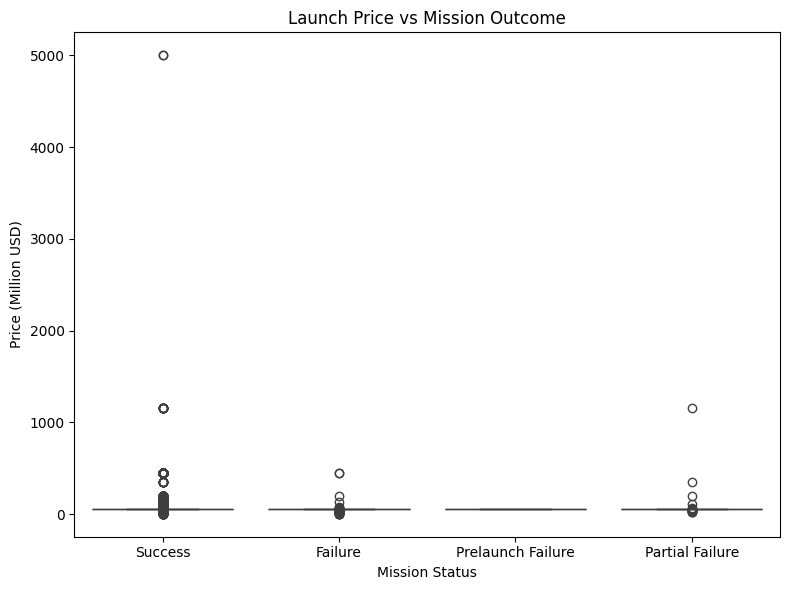

In [46]:
# Select Price and Mission_Status
price_outcome_pd = df_price.select("Price", "Mission_Status").toPandas()

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Mission_Status", y="Price", data=price_outcome_pd)
plt.title("Launch Price vs Mission Outcome")
plt.xlabel("Mission Status")
plt.ylabel("Price (Million USD)")
plt.tight_layout()
plt.show()


#### Chart - 7:

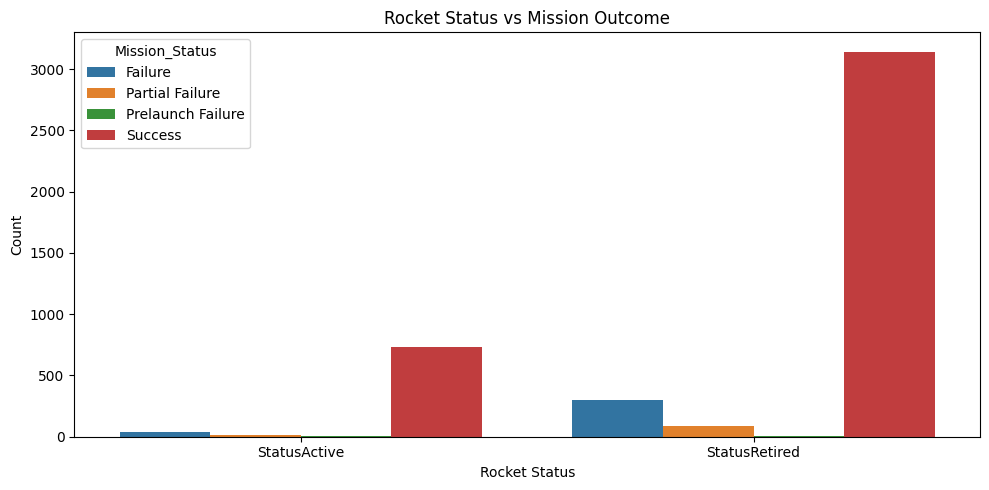

In [47]:
rocket_status_df = df.groupBy("Rocket_Status", "Mission_Status").count().orderBy("Rocket_Status", "Mission_Status")
rocket_status_pd = rocket_status_df.toPandas()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=rocket_status_pd, x="Rocket_Status", y="count", hue="Mission_Status")
plt.title("Rocket Status vs Mission Outcome")
plt.xlabel("Rocket Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


#### Chart - 8:

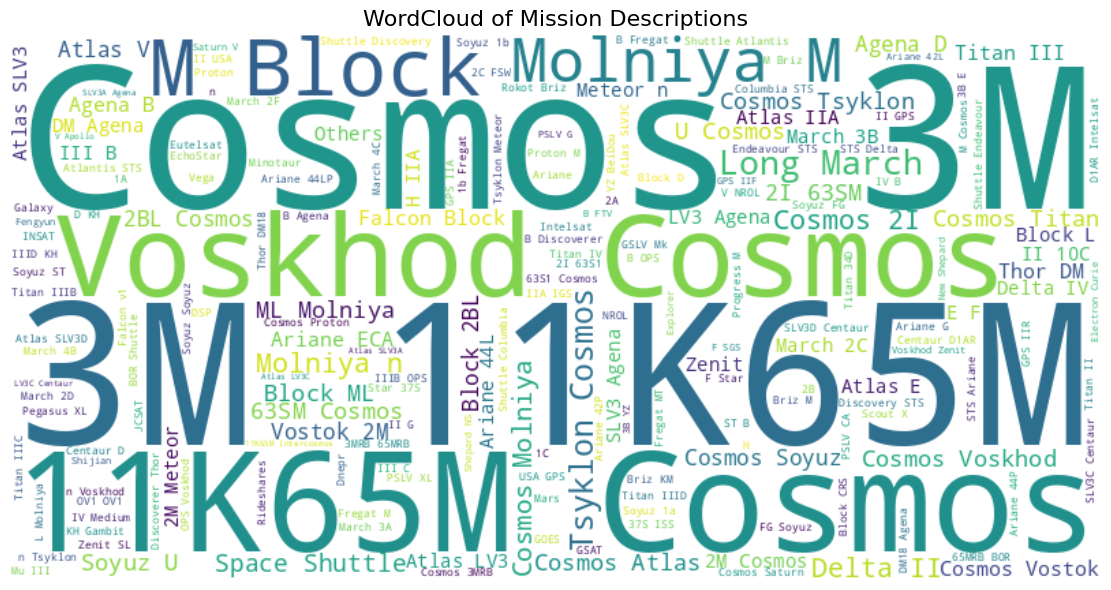

In [48]:
# Convert to pandas and drop nulls
details_pd = df.select("Detail").dropna().toPandas()

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all details into one text
text = " ".join(detail for detail in details_pd.Detail if detail)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Mission Descriptions", fontsize=16)
plt.tight_layout()
plt.show()


#### Chart - 9:

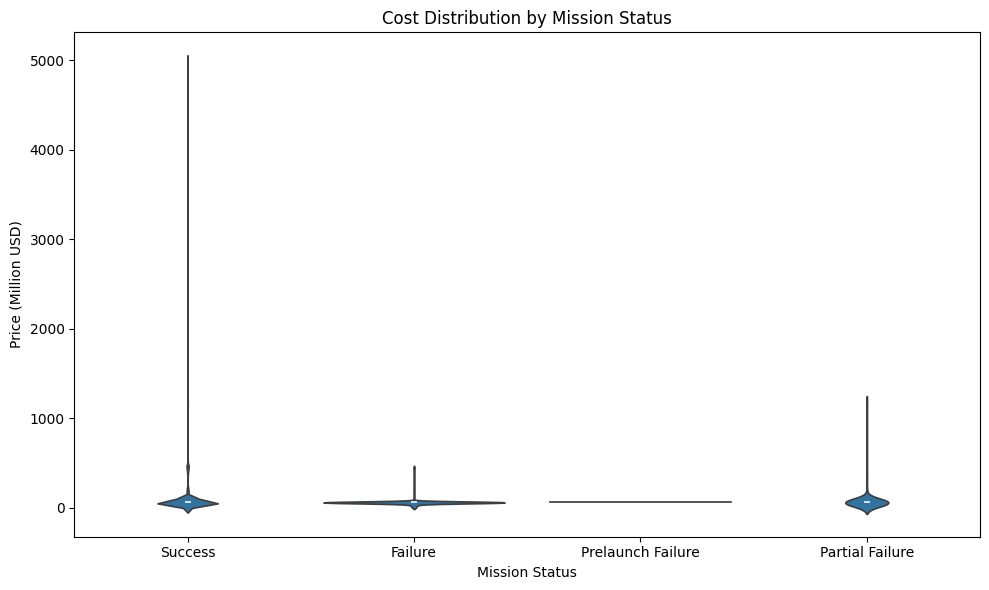

In [49]:
# Filter non-null prices
df_price = df.filter(df.Price.isNotNull())
price_status_pd = df_price.select("Price", "Mission_Status").toPandas()

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(x="Mission_Status", y="Price", data=price_status_pd)
plt.title("Cost Distribution by Mission Status")
plt.xlabel("Mission Status")
plt.ylabel("Price (Million USD)")
plt.tight_layout()
plt.show()


# **Feature Engineering**